In [1]:
%load_ext autoreload
%autoreload 2

import torch

#from lib.model.progen.init_model import init_model
from lib.model.progen.extended.init_model import init_model
from lib.model.train import train
from lib.model.progen.init_tokenizer import init_tokenizer
from lib.data.datasets.GB1 import get_GB1_dataset

s:\Documents\master\ProGen\progen\progen2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Tokenizer

In [4]:
tokenizer = init_tokenizer()
tokenize = lambda sequence: torch.tensor(tokenizer.encode(sequence).ids)

Model

In [4]:
model = init_model().to(device)
#model = init_model(state_dict_path="/models/progen_extended_0.pt")

Some weights of the model checkpoint at s:\Documents\master\code\llm\lib\model\progen/../../../../../ProGen/progen/progen2/checkpoints/progen2-small were not used when initializing ProGenModel: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing ProGenModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ProGenModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print([param for param in model.parameters()])

In [ ]:
model

Save / Load model states

In [17]:
import os

In [23]:
MODEL_PATH = os.getcwd() + "/models/progen_extended_0.pt"

In [24]:
#torch.save(model, MODEL_PATH)

torch.save(model.state_dict(), MODEL_PATH)

In [ ]:
#model = torch.load(MODEL_PATH)

# ! init the model first
model.load_state_dict(torch.load(MODEL_PATH))

Data

In [8]:
TEST_SPLIT = 500 / 149631

tokenize = lambda sequence: tokenizer.encode(sequence).ids

train_sequences, train_fitnesses, test_sequences, test_fitnesses = get_GB1_dataset(
    tokenize=tokenize,
    test_split=TEST_SPLIT,
    device=device,
)

s:\Documents\master\ProGen\progen\progen2\.venv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [13]:
N_DATA = 100

n_train = int(N_DATA * (1-TEST_SPLIT))
n_test = int(N_DATA * TEST_SPLIT)
train_sequences = train_sequences[0:n_train]
train_fitnesses = train_fitnesses[0:n_train]
test_sequences = test_sequences[0:n_test]
test_fitnesses = test_fitnesses[0:n_test]

Train

In [6]:
out = model.forward(train_sequences[0])
out.size()

torch.Size([56, 1])

In [ ]:
loss_history = train(
    model=model,
    device=device,

    train_data=train_sequences,
    train_labels=train_fitnesses,
    test_data=test_sequences,
    test_labels=test_fitnesses,

    loss_function=torch.nn.functional.mse_loss,
    batch_size=1,
    learning_rate=1e-3,
    n_epochs=1,
)

Results

Trained 0.9 data, tested on 0.1 data, shuffled

mean test loss = 1.2047
mean test loss = 0.3296

Trained on batches of size 1, tested on 0.1 data, shuffled

mean test-data loss = 2.927136182785034
s:\Documents\master\code\llm\lib\model\train.py:44: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_function(output, label)
mean test-data loss = 1.0202242136001587
Epoch 1:mean test-data loss = 0.7981275320053101
Epoch 2:mean test-data loss = 0.8598976135253906
Epoch 3:mean test-data loss = 0.8339541554450989
Epoch 4:mean test-data loss = 0.2656804621219635
Epoch 5:mean test-data loss = 0.22678536176681519
Epoch 6:mean test-data loss = 0.7484277486801147
Epoch 7:mean test-data loss = 0.7273379564285278
Epoch 8:mean test-data loss = 0.20019400119781494
Epoch 9:mean test-data loss = 0.2083941400051117
Epoch 10:mean test-data loss = 0.49960991740226746
Epoch 11:mean test-data loss = 0.4153096675872803
Epoch 12:mean test-data loss = 0.30266302824020386
Epoch 13:mean test-data loss = 0.3114781379699707
Epoch 14:mean test-data loss = 0.29903849959373474
Epoch 15:mean test-data loss = 0.2538512945175171
Epoch 16:mean test-data loss = 0.4101998507976532
Epoch 17:mean test-data loss = 0.41078630089759827
Epoch 18:mean test-data loss = 0.2096560150384903
Epoch 19:mean test-data loss = 0.19284088909626007
Epoch 20:mean test-data loss = 0.4778718650341034
Epoch 21:mean test-data loss = 0.4716760814189911
Epoch 22:mean test-data loss = 0.18762770295143127
Epoch 23:mean test-data loss = 0.8848859071731567
Epoch 24:mean test-data loss = 1.1906050443649292
Epoch 25:mean test-data loss = 1.0409295558929443
Epoch 26:mean test-data loss = 0.4904017448425293
Epoch 27:mean test-data loss = 0.5127981901168823
Epoch 28:mean test-data loss = 0.8855107426643372
Epoch 29:mean test-data loss = 0.8350266218185425

Train Progen Extended

In [1]:
%load_ext autoreload
%autoreload 2

from progen_extended import train_progen_extended

s:\Documents\master\ProGen\progen\progen2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
loss_history = train_progen_extended(
    state_dict_path="",
    save_state_dict="/models/progen_extended_tmp2.pt",
    save_history="/models/progen_extended_tmp2_history.pt",
)

Sandbox

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
loss_history = torch.load("./models/progen_extended_v1_history.pt")

In [3]:
loss_history.size()

torch.Size([2, 149])

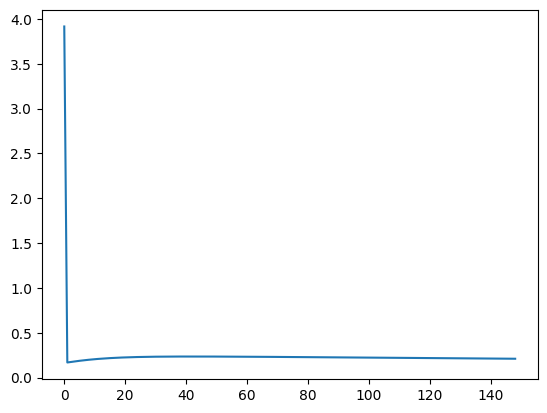

In [12]:
plt.plot([b for b in range(loss_history.size()[1])], [l for l in loss_history[1,:]])
plt.show()